In [34]:
import os, sys, torch
sys.path.append('../')
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from utils.spectrum import read_spectrum, norm_spectrum, wave_unit_converters
from utils.visualize import clustering_summary, clustering_details, plot_map
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# main input file
input_file = '/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/902.txt'

# default parameters
num_clusters = 8
num_exmaples = 7
have_substrate = False
random_state = 100

- PCA + K-means

In [3]:
x, y = read_spectrum(input_file)

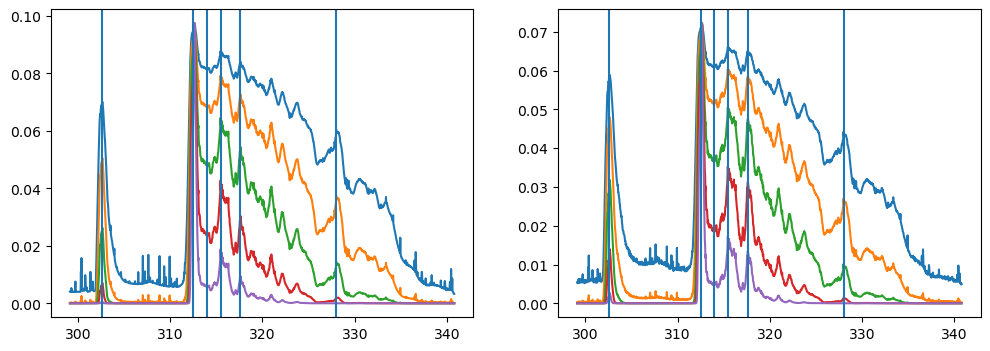

In [57]:
nx, n1, n2 = y.shape
f, axs = plt.subplots(1,2,figsize=(12,4))
vmin, vmax, ny = norm_spectrum(y, num_bit=0)
spectrums = ny.reshape(nx, -1).T
buffer = np.zeros((nx, n1*n2))
for i in range(5):
    ny_std = np.hstack([ny.reshape(nx, -1), buffer]).std(1).reshape(-1)
    std_min, std_max, _ = norm_spectrum(ny_std, num_bit=0)
    
    ny = ny_std.reshape(-1,1,1) * ny
    _, _, ny = norm_spectrum(ny, num_bit=0)
    axs[1].plot(x, ny_std)

vmin, vmax, ny = norm_spectrum(y, num_bit=0)
for i in range(5):
    ny_std = ny.reshape(nx, -1).std(1).reshape(-1)
    std_min, std_max, _ = norm_spectrum(ny_std, num_bit=0)
    
    ny = ny_std.reshape(-1,1,1) * ny
    _, _, ny = norm_spectrum(ny, num_bit=0)
    axs[0].plot(x, ny_std)
vls = [302.6, 312.5, 314, 315.5, 317.6, 328]
for ax in axs:
    for l in vls: ax.axvline(l)

In [91]:
print(wave_unit_converters['nm']['eV'](np.array([302. 312.4, 316.1, 322.1, 324, 327.7, 333])))
print(wave_unit_converters['eV']['nm'](np.array([4.1, 3.97, 3.9, 3.7])))

[4.09729671 3.96749435 3.94854135 3.92976857 3.90378459 3.78000605]
[302.40048398 312.30276683 317.90820111 335.0924282 ]


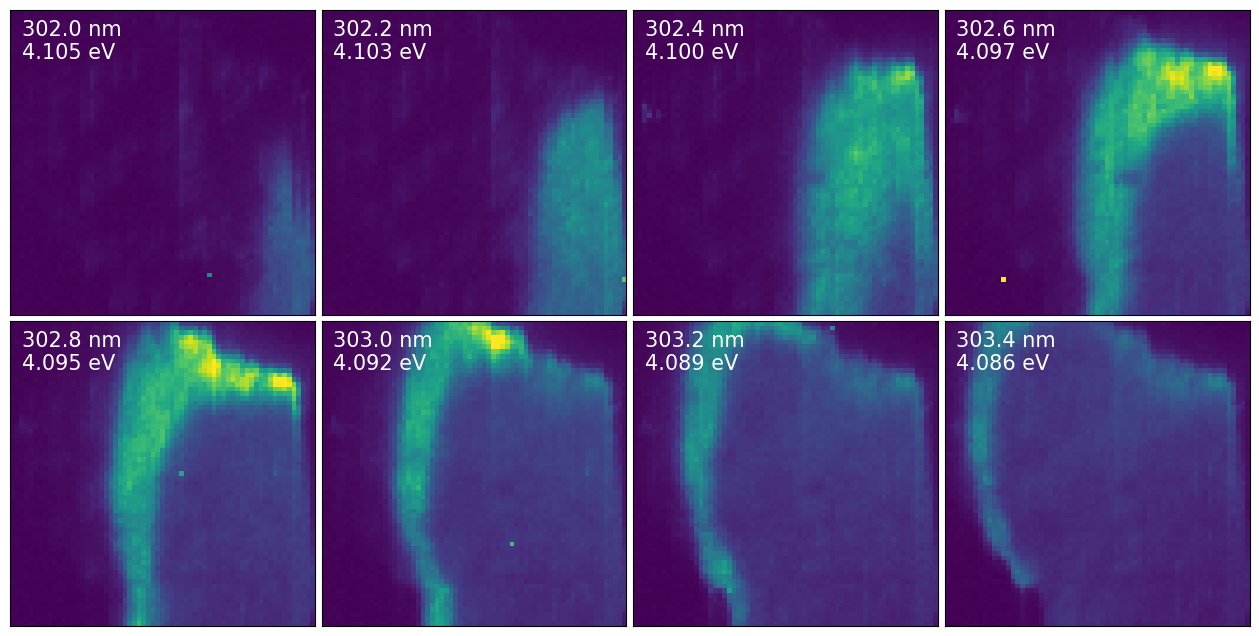

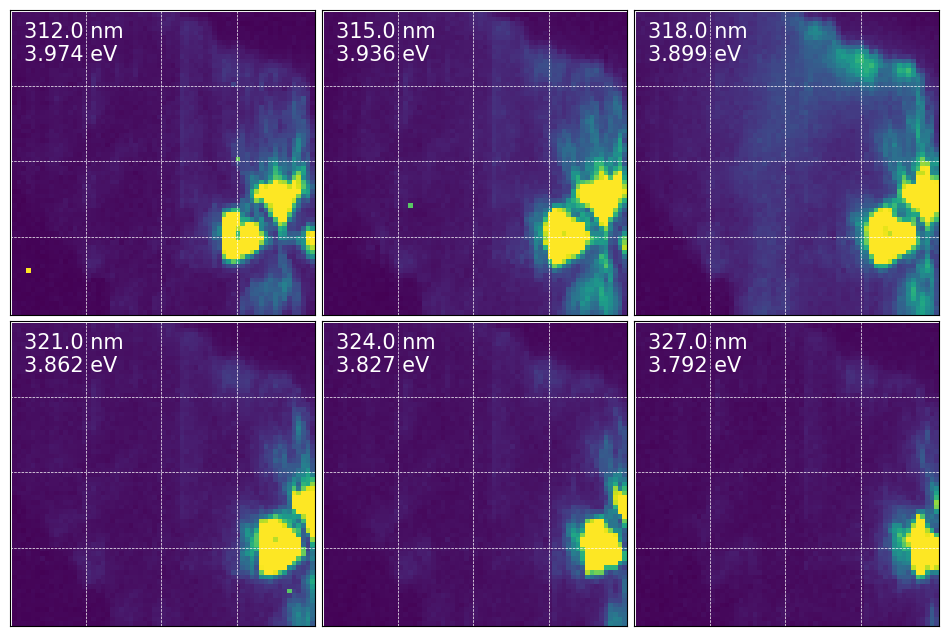

In [50]:
f, axs = plt.subplots(2,4, figsize=(16, 8))
for l, ax in zip([302.0, 302.2, 302.4, 302.6, 302.8, 303.0, 303.2, 303.4], axs.reshape(-1)):
    plot_map(ax, x, y.transpose(0,2,1), l, tol=0.05, vmax=1500)    
    e = wave_unit_converters['nm']['eV'](np.array([l]))[0]
    ax.text(62,54,f'{l:.1f} nm\n{e:.3f} eV', color=[1,1,1], fontsize=15)
    ax.invert_xaxis()
    ax.invert_yaxis()
f.subplots_adjust(hspace=0.02, wspace=0.02)

f, axs = plt.subplots(2,3, figsize=(12, 8))
#for l, ax in zip([312.1, 315.0, 316.1, 322.1, 324.0, 327.7, 333.0], axs.reshape(-1)):
for l, ax in zip([312.0, 315.0, 318.0, 321.0, 324.0, 327.0, 330.0], axs.reshape(-1)):
    plot_map(ax, x, y.transpose(0,2,1), l, tol=0.05, vmax=1000, grid=True)
    e = wave_unit_converters['nm']['eV'](np.array([l]))[0]
    ax.text(62,54,f'{l:.1f} nm\n{e:.3f} eV', color=[1,1,1], fontsize=15)

    ax.invert_xaxis()
    ax.invert_yaxis()
f.subplots_adjust(hspace=0.02, wspace=0.02)

In [75]:
x, y = read_spectrum(input_file)

nx, n1, n2 = y.shape

vmin, vmax, ny = norm_spectrum(y, num_bit=0)
spectrums = ny.reshape(nx, -1).T
buffer = np.zeros((nx, n1*n2))
for i in range(0):
    ny_std = np.hstack([ny.reshape(nx, -1), buffer]).std(1).reshape(-1)
    std_min, std_max, _ = norm_spectrum(ny_std, num_bit=0)
    mask = ny_std > std_min
    if np.sum(mask) < nx * 0.5: break
    
    ny = ny_std.reshape(-1,1,1) * ny
    _, _, ny = norm_spectrum(ny, num_bit=0)

masked_spectrum = ny.reshape(nx, -1).T[..., mask]

pca = PCA(n_components=20)
pca_vector = pca.fit_transform(masked_spectrum)

# find substrate
mask_sample = np.ones(pca_vector.shape[0], dtype=bool)
if have_substrate:
    gm_sub = BayesianGaussianMixture(n_components=3, random_state=random_state, covariance_type='spherical')
    l_sub = gm_sub.fit_predict(pca_vector)
    mask_sample = l_sub != np.argmin([masked_spectrum[l_sub == i].std(1).mean() for i in range(3)])
    
# clustering sample area
gm = BayesianGaussianMixture(n_components=num_clusters, random_state=random_state, covariance_type='spherical')
tsne = TSNE(perplexity=50, init='pca', random_state=random_state, learning_rate='auto')
tsne_vector = tsne.fit_transform(masked_spectrum[mask_sample])
l1 = gm.fit_predict(pca_vector[mask_sample])

labels = np.ones(n1*n2, dtype=int) * -1
if len(np.unique(l1)) != num_clusters:
    print('Number of clusters changed: {} -> {}'.format(num_clusters, len(np.unique(l1))))
    for i, j in enumerate(np.unique(l1)):
        l1[l1 == j] = i
    num_clusters = len(np.unique(l1))
l2 = l1.copy()
for i, j in enumerate(sorted(np.unique(l1), key=lambda x: masked_spectrum[mask_sample][l1 == x].var(1).mean())):
    l2[l1 == j] = i

labels[mask_sample] = l2

labels = labels.reshape(n1,n2)

/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


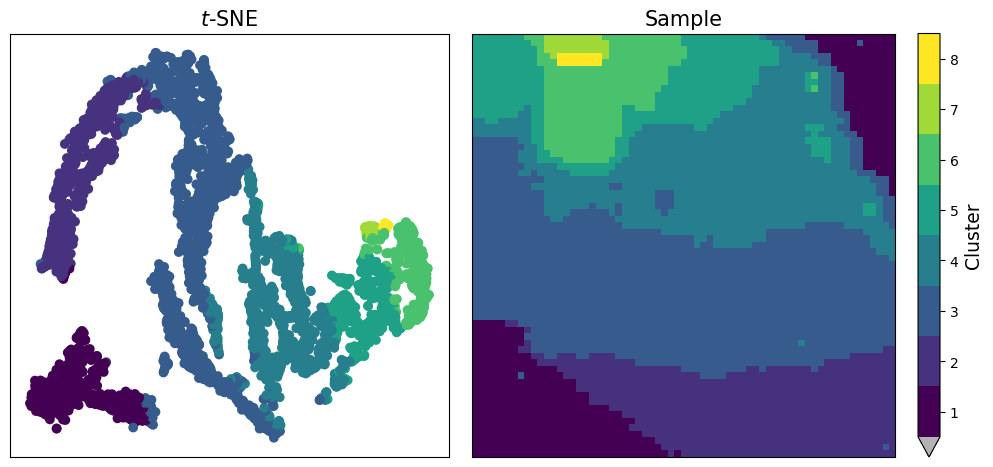

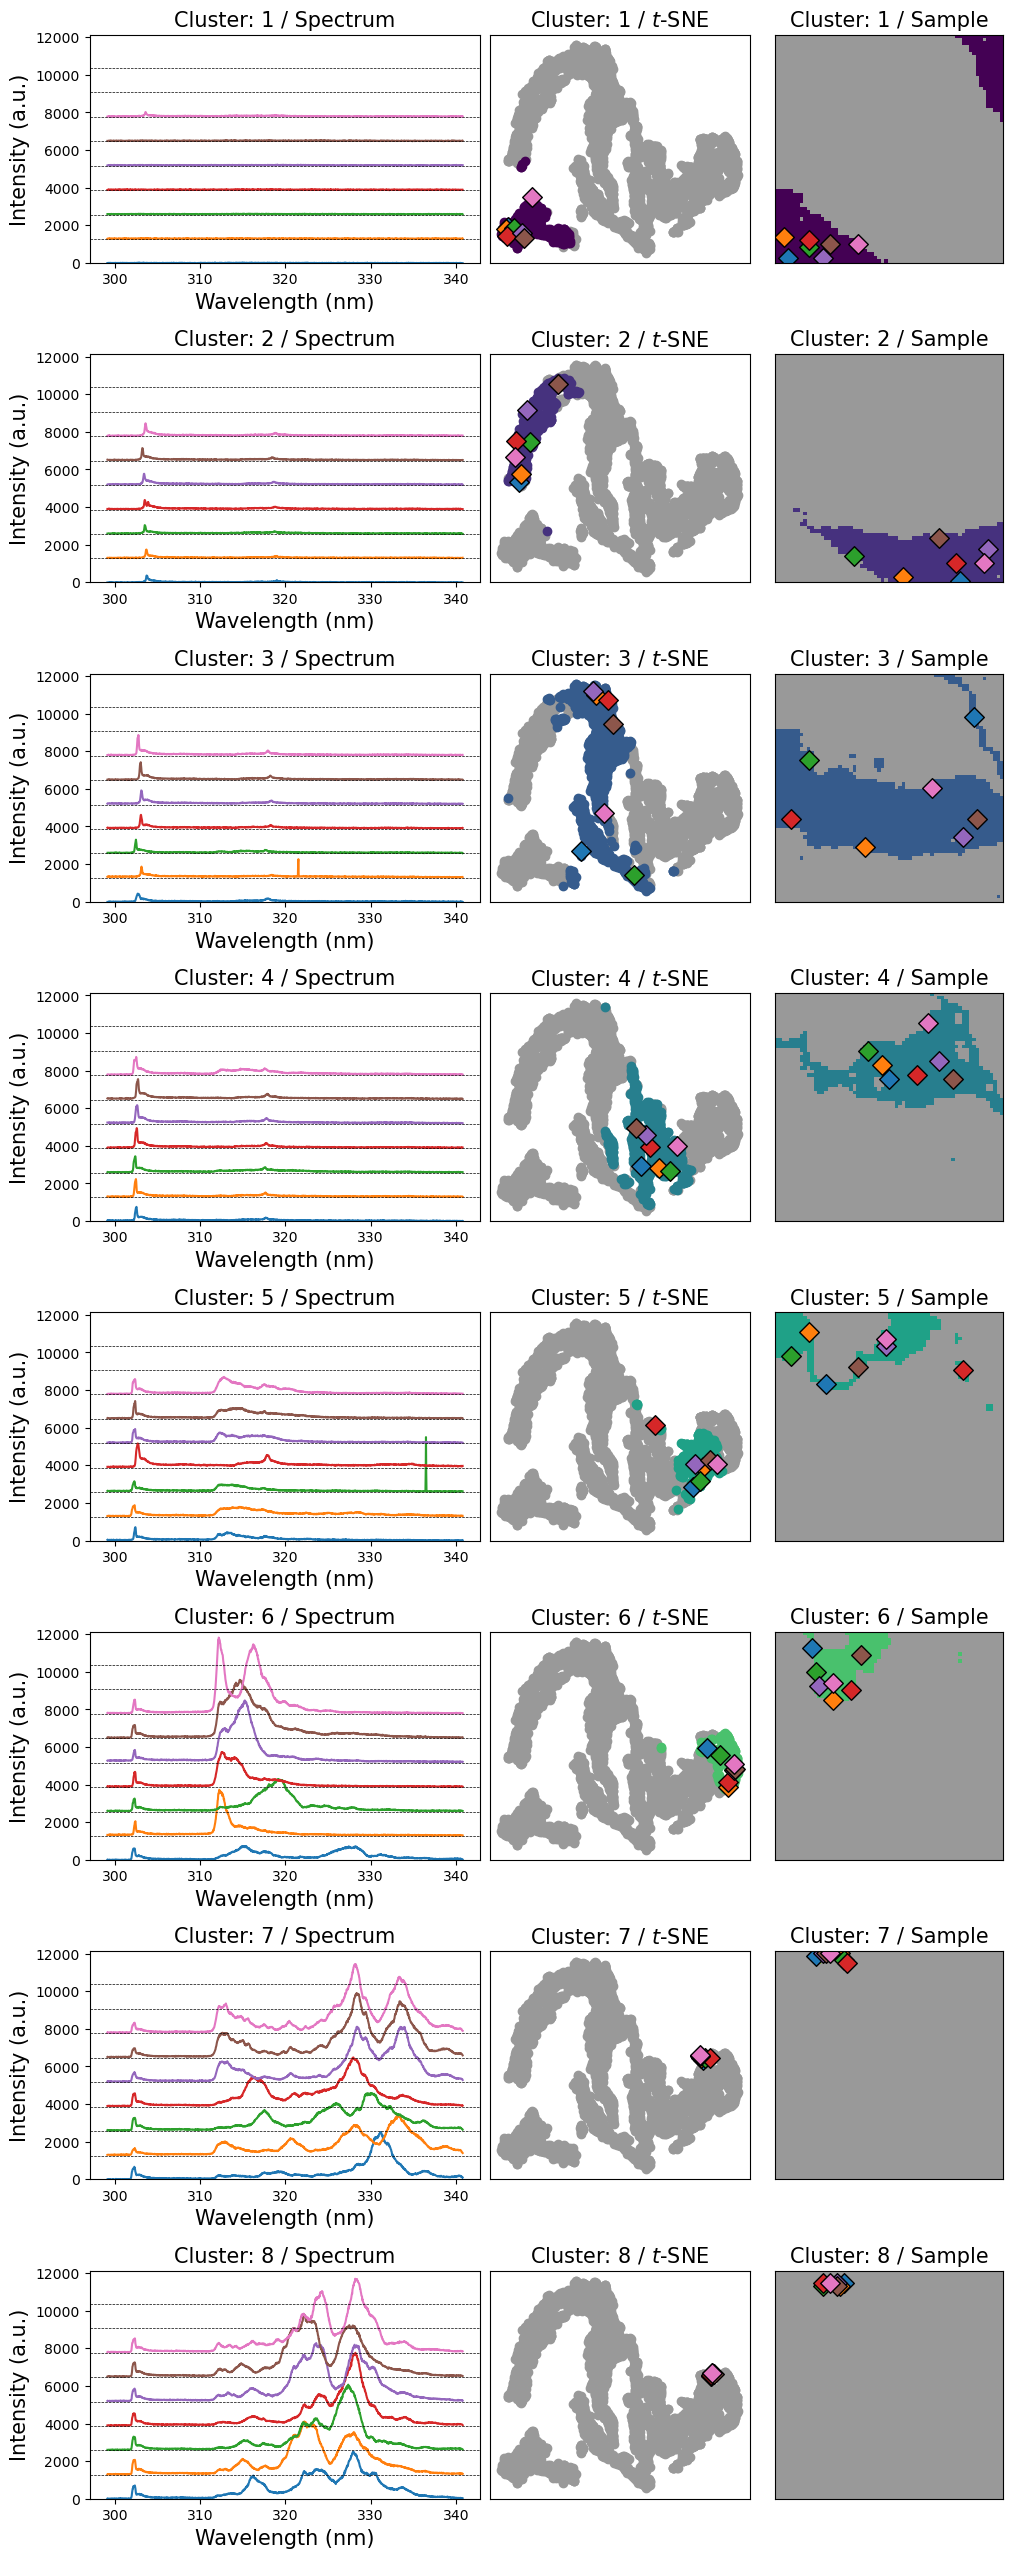

In [76]:
_ = clustering_summary(tsne_vector, labels)
_ = clustering_details(x, y, tsne_vector, labels, num_exmaples)

In [ ]:
from srs.snet import SpectrumAutoEncoder


SpectrumAutoEncoder(1, )

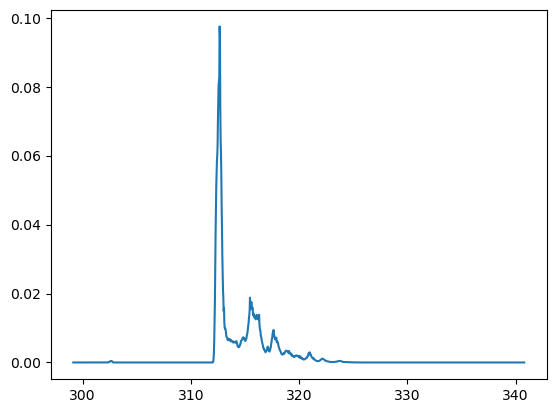

In [14]:
plt.plot(x, ny_std)